# Heart Disease Prediction

## Guidelines

1. Introduction: You will briefly describe your data set and the problem you are trying
to solve.
2. Perform some unsupervised analysis: Look to see if any interesting structure
is present in the data. If you don’t find any interesting structure, describe what you
tried.
3. Supervised analysis: You must train at least three of the learning models discussed
in the class (e.g., Logistic regression, SVM, Neural Networks).1 For each model, you
must try different feature transformations and different regularization techniques.
2
For example, try the linear, polynomial, and radial-basis function kernel if you use
support vector machines in your project. Remember to illustrate (through graphs)
how your feature weights and error changed when you used different parameters,
regularizations, and normalizations.
4. Table of Results: You must create a table that contains the final results for your
model. It would be useful to have a table that includes the training accuracy and the
validation accuracy for every model you created. For example, suppose you’re using
Ridge Regression and manipulating the value of λ. In that case, your table should
contain the training and validation accuracy for every lambda value you used. You
should provide the precision and recall
5. Why: Your write-up should analytically discuss your experimental findings; and
what conclusions you can draw from your work. You should appeal to the concepts
discussed in class: overfitting, underfitting, variance, bias, etc.


## Import packages

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn import compose

## Data Preprocessing

### Loading the data

In [40]:
data_df = pd.read_csv('heart.csv')
data_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### Encoding Features

In [41]:
sex_oh_enc = pd.get_dummies(data_df["Sex"], dtype="int").rename(columns={"F":"Female", "M":"Male"})
chestPain_oh_enc = pd.get_dummies(data_df["ChestPainType"], dtype="int").rename(columns={"TA":"ChestPain_TA", "ATA":"ChestPain_ATA", "NAP":"ChestPain_NAP","ASY":"ChestPain_ASY"})
restECG_oh_enc = pd.get_dummies(data_df["RestingECG"], dtype="int").rename(columns={"Normal":"RestECG_Normal", "ST":"RestECG_ST", "LVH":"RestECG_LVH"})
st_slope_oh_enc = pd.get_dummies(data_df["ST_Slope"], dtype="int").rename(columns={"Up":"ST_Slope_Up", "Flat":"ST_Slope_Flat", "Down":"ST_Slope_Down"})
exerciseAngina_ord_enc = pd.DataFrame(pd.factorize(data_df["ExerciseAngina"])[0], columns=["ExerciseAngina"])

data_df_encoded = data_df.drop(columns=["Sex", "ChestPainType", "RestingECG", "ST_Slope", "ExerciseAngina"])
data_df_encoded = data_df_encoded.join([sex_oh_enc, chestPain_oh_enc, restECG_oh_enc, st_slope_oh_enc, exerciseAngina_ord_enc])
data_df_encoded = data_df_encoded[["Age",
                                  "Male", "Female",
                                  "ChestPain_TA", "ChestPain_ATA", "ChestPain_NAP", "ChestPain_ASY",
                                  "RestingBP",
                                  "Cholesterol",
                                  "FastingBS",
                                  "RestECG_Normal", "RestECG_ST", "RestECG_LVH",
                                  "MaxHR",
                                  "ExerciseAngina",
                                  "Oldpeak",
                                  "ST_Slope_Up", "ST_Slope_Flat", "ST_Slope_Down",
                                  "HeartDisease"]]
categorical_columns = ["Male", "Female", "ChestPain_TA", "ChestPain_ATA", "ChestPain_NAP", "ChestPain_ASY", "FastingBS", "RestECG_Normal", "RestECG_ST", "RestECG_LVH", "ExerciseAngina", "ST_Slope_Up", "ST_Slope_Flat", "ST_Slope_Down", "HeartDisease"]
for col in categorical_columns:
    data_df_encoded[col] = data_df_encoded[col].astype("category")
feature_names = data_df_encoded.columns
data_df_encoded

,Age,Male,Female,ChestPain_TA,ChestPain_ATA,ChestPain_NAP,ChestPain_ASY,RestingBP,Cholesterol,FastingBS,RestECG_Normal,RestECG_ST,RestECG_LVH,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_Up,ST_Slope_Flat,ST_Slope_Down,HeartDisease
0,40,1,0,0,1,0,0,140,289,0,1,0,0,172,0,0.0,1,0,0,0
1,49,0,1,0,0,1,0,160,180,0,1,0,0,156,0,1.0,0,1,0,1
2,37,1,0,0,1,0,0,130,283,0,0,1,0,98,0,0.0,1,0,0,0
3,48,0,1,0,0,0,1,138,214,0,1,0,0,108,1,1.5,0,1,0,1
4,54,1,0,0,0,1,0,150,195,0,1,0,0,122,0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,0,1,0,0,0,110,264,0,1,0,0,132,0,1.2,0,1,0,1
914,68,1,0,0,0,0,1,144,193,1,1,0,0,141,0,3.4,0,1,0,1
915,57,1,0,0,0,0,1,130,131,0,1,0,0,115,1,1.2,0,1,0,1
916,57,0,1,0,1,0,0,130,236,0,0,0,1,174,0,0.0,0,1,0,1


### Separating features from target

In [11]:
X = np.array(data_df_encoded)[:,:-1]
y = np.array(data_df_encoded)[:,-1].reshape(918,1)

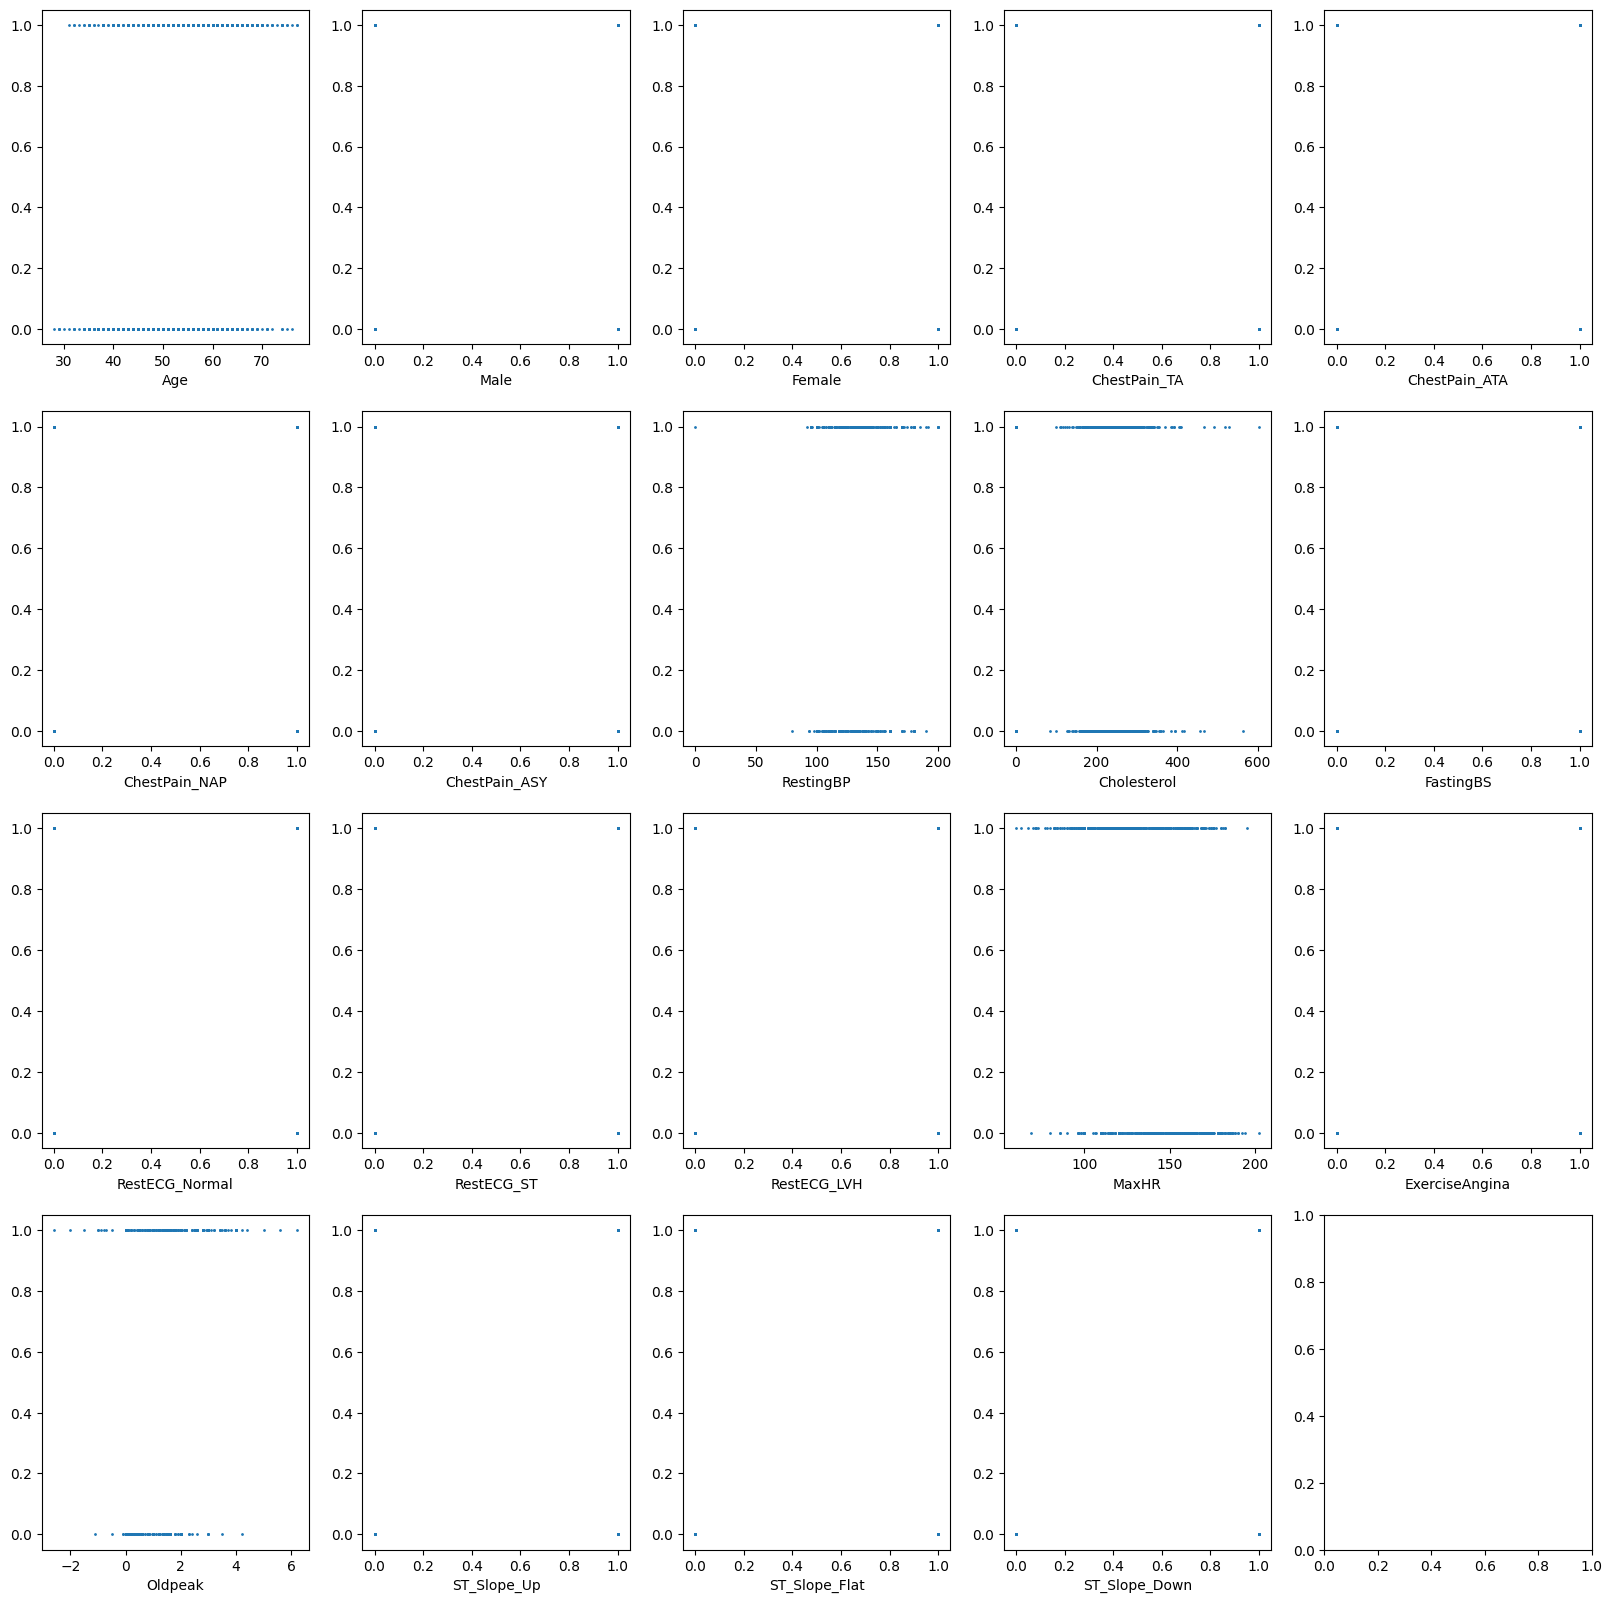

In [29]:
fig, axs = plt.subplots(4, 5, figsize=(20,20))
for idx, ax in enumerate(axs.ravel()[:-1]):
   ax.scatter(X[:,idx], y, s=1)
   ax.set_xlabel(feature_names[idx])

### Splitting data into train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=8)

### Feature Scaling/Normalization

In [7]:
# Normalize age, RestingBP, Cholesterol, MaxHR, and oldPeak

# Standardization (Z-score normzalization): zero-centered & unit variance
# ct = compose.ColumnTransformer([("standard_scaler", preprocessing.StandardScaler(), [0, 7, 8, 13, 15])], remainder="passthrough")

# Min/Max Normalization (Linear Scaling): [0,1]
ct = compose.ColumnTransformer([("min_max_scaler", preprocessing.MinMaxScaler(), [0, 7, 8, 13, 15])], remainder="passthrough")


X_train_normalized = ct.fit_transform(X_train)
X_test_normalized = ct.fit_transform(X_test)

### Add column of ones to data

In [8]:
X_train_normalized_1 = np.hstack((np.ones((X_train.shape[0],1)), X_train))
X_test_normalized_1 = np.hstack((np.ones((X_test.shape[0],1)), X_test))

## Logistic Regression

### Feature Transformations

### Regularization

### Hyperparameter Tuning